In [31]:
# %%
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 7) # make bigger plots

import numpy as np
import pandas as pd
import sklearn.metrics

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA,ARMA

In [32]:
%%capture
# create loading bar
from tqdm.notebook import tqdm
tqdm().pandas()

In [33]:
folder = 'C:/Users/Lorenzo/Desktop/MyStuff/Master/Paris/Bloom/data/'

count_ig_csv = folder + 'emerging_risks_doc_count_instagram.csv'
count_tw_csv = folder + 'emerging_risks_doc_count_twitter.csv'
engagement_fb_csv = folder + 'emerging_risks_local_engagement_facebook.csv'
engagement_ig_csv = folder + 'emerging_risks_local_engagement_instagram.csv'
engagement_tw_csv = folder + 'emerging_risks_local_engagement_twitter.csv'
files = [count_ig_csv, count_tw_csv, engagement_fb_csv, engagement_ig_csv, engagement_tw_csv]

In [34]:
# %%
df = pd.read_csv(count_tw_csv)

try:
    df.drop([381, 382, 383], inplace=True) # drop rows 381, 382, 383 as they are 0 values
    df.date = pd.to_datetime(df.date)
    df.set_index('date', inplace=True)                  # set date as index
    df = df.asfreq('d')
except KeyError:                          # pass if rows 381, 382, 383 have already been dropped
    print("KeyError")
    pass

In [35]:
weekly = df.rolling(7).mean()[7:]
smoothed = df.rolling(9).mean()[9:]

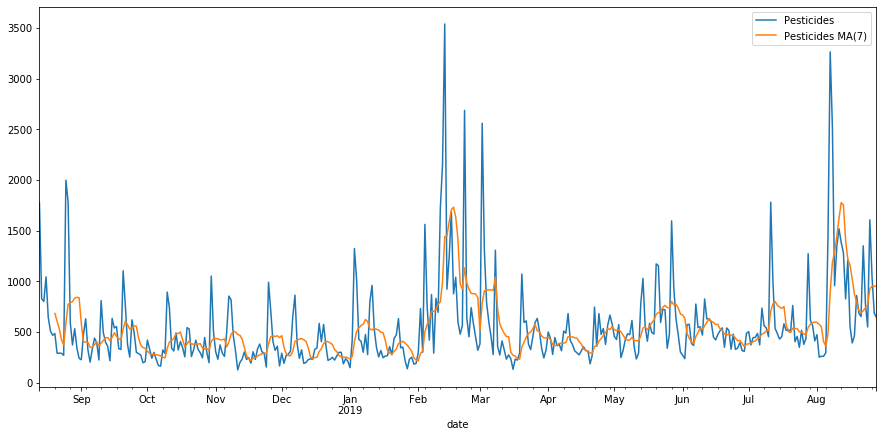

In [36]:
df.Pesticides.plot(label="Pesticides")
weekly.Pesticides.plot(label="Pesticides MA(7)")
plt.legend()

In [97]:
train_len = 300
topic = "Farmer"

In [137]:
test_ARIMA_model = SARIMAX(weekly[topic][:train_len], order=(9, 0, 4)).fit()

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [129]:
test_MA_model = SARIMAX(weekly[topic][:train_len], order=(0, 0, 4)).fit()

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [139]:
test_AR_model = SARIMAX(weekly[topic][:train_len], order=(9, 0, 0)).fit()

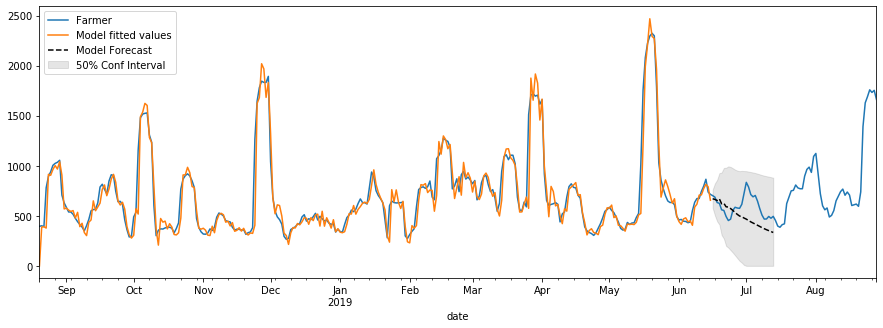

In [138]:
confidence_interval = 0.5
fcast = test_ARIMA_model.get_forecast(28).summary_frame(alpha=1 - confidence_interval)    
prediction = fcast['mean']
    
# replace negative values with 0 because they are impossible
fcast['mean_ci_lower'] = [x if x>=0 else 0 for x in fcast['mean_ci_lower']]
fcast['mean_ci_upper'] = [x if x>=0 else 0 for x in fcast['mean_ci_upper']]

fig, ax = plt.subplots(figsize=(15, 5))
        
# Plot the data (here we are subsetting it to get a better look at the forecasts)
weekly[topic].plot(ax=ax, label=f"{topic}")
test_SARIMAX_model.fittedvalues.plot(ax=ax, label="Model fitted values")

# Construct the forecasts
prediction.plot(ax=ax, style='k--', label="Model Forecast")
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1, 
                label=f"{int(confidence_interval*100)}% Conf Interval")
plt.legend(loc="upper left")

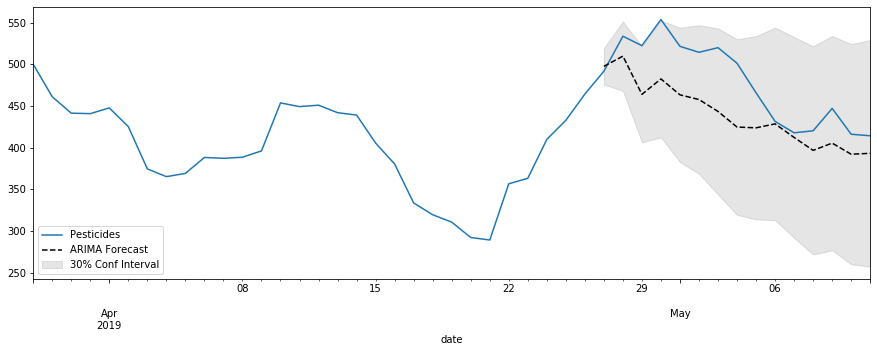

In [20]:
CONF_INT = 0.3
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
weekly.Pesticides[220:265].plot(ax=ax, label="Pesticides")

# Construct the forecasts
fcast = test_SARIMAX_model.get_forecast(15).summary_frame(alpha=1-CONF_INT)
fcast['mean'].plot(ax=ax, style='k--', label="ARIMA Forecast")
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1, 
                label=f"{int(CONF_INT*100)}% Conf Interval")

plt.legend(loc="lower left")

In [74]:
def mean_absolute_percentage_error(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError(f"len y_true is {len(y_true)}, len y_pred is {len(y_true)}" )
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [142]:
res = sm.tsa.stattools.arma_order_select_ic(x, ic=['aic'])

NameError: name 'x' is not defined

In [165]:
ARMA(weekly.CEO, order=(7,0,4)).fit()

In [30]:
# THIS CELL TAKES 3 mins: store Arima model for every column and 10 days forecasts

# models = dict()        # store models so no need to rerun
# forecasts10 = dict()   # forecasts of next 10 days
# 
# for col in tqdm(weekly.columns):
#     train = weekly[col][:200]
#     # test = weekly[col][200:]
#     ARIMA_model = SARIMAX(train, order=(7, 0, 4)).fit()        
#     models[col] = ARIMA_model   
#     prediction = ARIMA_model.predict(200, 210)  
#     forecasts10[col] = prediction

# after a few tests, dict comprehension reduced execution time by 1 minute (33%)
models = {col: SARIMAX(weekly[col][:200], order=(7, 0, 4)).fit() for col in tqdm(weekly.columns) if sum(
    weekly[col]==0) < 200} 
forecasts10 = {col: model.predict(200, 210) for col, model in models.items()}

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceW

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

In [190]:
len(forecasts10.keys())

102

In [191]:
rmses = dict()

for k,v in forecasts10.items():
    rmses[k] = sklearn.metrics.mean_squared_error(weekly[k][200:202], v[0:2], squared=False)

In [195]:
mapes = dict()

for k,v in forecasts10.items():
    if 0.0 not in weekly[k][200:202].values:
        mape = mean_absolute_percentage_error(weekly[k][200:202], v[0:2])
        mapes[k] = round(mape, 2)
    else:
        print(k)
        mapes[k] = None


Atrazine
Perchlorate
Genetically_Modified_Animal
Milk_Sales


In [196]:
mapes

{'Farmer': 6.59,
 'Pesticides': 18.92,
 'Food_Contamination': 5.77,
 'Industry': 22.8,
 'Dairy_Health_Impact': 9.16,
 'Forest': 12.41,
 'Waste': 0.81,
 'Workers': 8.08,
 'Cow': 13.66,
 'Government': 48.04,
 'ImportExport': 14.07,
 'Chemical': 29.09,
 'Deforestation_Agriculture': 38.83,
 'Lactose_Intolerant': 80.71,
 'Food_Climat_Impact': 20.91,
 'Employment': 25.49,
 'Policy': 6.23,
 'Poverty': 2.84,
 'Biodiversity': 174.55,
 'Price': 7.44,
 'Brexit': 48.0,
 'Food_Waste': 13.6,
 'Industrial_Agriculture': 29.16,
 'Soil': 43.15,
 'Natural': 188.29,
 'Payment_Wages': 5.3,
 'Cancer': 5.93,
 'MentalHealth': 25.69,
 'GMO': 4.5,
 'Sugar': 14.45,
 'Factory': 2.06,
 'Packaging': 20.27,
 'PalmOil': 56.19,
 'Immigration': 42.28,
 'Taste': 1.03,
 'Pollinators': 35.61,
 'Shortage': 24.02,
 'Glyphosate': 12.62,
 'Animal_Welfare': 16.53,
 'CEO': 204.91,
 'Recycling': 7.3,
 'Vegan_Against_Dairy': 7.0,
 'Almond_milk': 5.94,
 'Vitamin': 9.22,
 'Allergy': 72.98,
 'Gut_Digestion': 2.25,
 'Ingredient_Scrut

In [197]:
mapes_val = list(mapes.values())

summa = 0
count = 0
for el in mapes_val:
    if el is not None:
        count += 1
        summa += el

summa /(count)

29.708469387755095

In [134]:
def ci_accuracy(test, lower, upper):
    """
    Measure if real test value is inside confidence interval.
    """
    tp, tn = 0, 0
    for index, elem in enumerate(test):
        if elem < upper[index] and elem > lower[index]:
            tp += 1
        else:
            tn += 1
    
    return tp / (tp + tn)

In [143]:
def get_mean(lst):
    return sum(lst) / len(lst)

In [213]:
ci_precision = dict()

check_length = 20
for column_name, model in models.items():
    test = weekly[column_name][200: 200 + check_length]
    ci = model.get_forecast(check_length).conf_int(alpha=0.4) # confidence interval at 80%
    
    lower_ci = list(ci[f"lower {column_name}"])
    upper_ci = list(ci[f"upper {column_name}"])
    
    ci_precision[column_name] = ci_accuracy(test, lower_ci, upper_ci)
    print(column_name, abs(get_mean(upper_ci)) - abs(get_mean(lower_ci)))

Farmer 1069.0378556896474
Pesticides 533.1682953427531
Food_Contamination 327.1443197698091
Industry 167.54658920186102
Dairy_Health_Impact -11.862465924114758
Forest 134.16747007859362
Waste 233.50942867443402
Workers 79.82663143077315
Cow 33.46810833518765
Government 55.709838941908004
ImportExport 228.25981240018723
Chemical 139.3693493672567
Deforestation_Agriculture 53.68271027323627
Lactose_Intolerant -40.597056491630156
Food_Climat_Impact 113.39132627794827
Employment 175.12108290545865
Policy 59.917261896357815
Poverty 47.30652464758765
Biodiversity 420.31234527970156
Price 110.50518461570923
Brexit 106.28112179462822
Food_Waste 55.134929971918
Industrial_Agriculture 46.917877518656304
Soil 43.01293999008713
Natural 136.55176512666745
Payment_Wages 114.87855849356347
Cancer 44.96606872414483
MentalHealth 116.98963191391687
GMO 35.58068342440758
Sugar 60.92794084881835
Factory 39.144593171298666
Packaging 28.278578359176475
PalmOil 10.760556721076732
Immigration 11.4918921194540

In [214]:
ci_precision

{'Farmer': 0.9,
 'Pesticides': 0.4,
 'Food_Contamination': 0.8,
 'Industry': 0.3,
 'Dairy_Health_Impact': 1.0,
 'Forest': 0.6,
 'Waste': 1.0,
 'Workers': 1.0,
 'Cow': 1.0,
 'Government': 1.0,
 'ImportExport': 0.0,
 'Chemical': 0.5,
 'Deforestation_Agriculture': 0.55,
 'Lactose_Intolerant': 1.0,
 'Food_Climat_Impact': 1.0,
 'Employment': 0.9,
 'Policy': 1.0,
 'Poverty': 1.0,
 'Biodiversity': 0.8,
 'Price': 1.0,
 'Brexit': 1.0,
 'Food_Waste': 0.85,
 'Industrial_Agriculture': 0.6,
 'Soil': 0.85,
 'Natural': 0.7,
 'Payment_Wages': 1.0,
 'Cancer': 0.6,
 'MentalHealth': 0.2,
 'GMO': 0.75,
 'Sugar': 1.0,
 'Factory': 0.45,
 'Packaging': 0.4,
 'PalmOil': 0.35,
 'Immigration': 0.65,
 'Taste': 1.0,
 'Pollinators': 0.55,
 'Shortage': 1.0,
 'Glyphosate': 0.45,
 'Animal_Welfare': 0.45,
 'CEO': 1.0,
 'Recycling': 0.15,
 'Vegan_Against_Dairy': 0.85,
 'Almond_milk': 0.9,
 'Vitamin': 0.7,
 'Allergy': 1.0,
 'Gut_Digestion': 0.65,
 'Ingredient_Scrutiny': 0.9,
 'Fats': 0.65,
 'Lactose': 1.0,
 'Seeds': 1.0,

In [215]:
get_mean(ci_precision.values())

0.7524509803921572

In [14]:
forecasts_df = pd.DataFrame(forecasts10)

In [15]:
forecasts_df

,Farmer,Pesticides,Food_Contamination,Industry,Dairy_Health_Impact,Forest,Waste,Workers,Cow,Government,...,Traceability,NanoParticles,Aluminium,Probiotics,Atrazine,Perchlorate,Dairy_Industry_Lie,Genetically_Modified_Animal,Milk_Sales,Overpackaging
2019-03-08,831.775683,1094.757964,404.233915,320.267710,73.599417,152.685869,186.247621,155.784031,128.187198,104.834751,...,0.294892,1.377296,0.499917,1.078212,-0.200831,0.029593,0.327553,-0.023367,0.020141,-0.000412
2019-03-09,820.177043,964.856354,249.621644,344.304103,89.909509,132.950260,176.964965,155.808577,105.840896,102.312891,...,0.161235,1.000755,0.106116,1.179188,-0.280657,0.023501,0.398857,-0.117241,0.004515,0.000114
2019-03-10,875.574686,886.290301,150.492067,380.966166,47.130384,124.778953,162.908126,115.915008,82.008279,67.341145,...,0.153414,0.998066,-0.048599,1.286401,-0.093234,0.000939,0.201362,-0.091036,-0.029438,-0.000126
2019-03-11,839.905432,986.573154,83.754044,404.019970,-58.025756,110.687767,146.123107,85.783463,67.951862,31.649542,...,0.099084,1.064119,-0.097571,1.256829,0.042474,0.004803,0.269834,-0.101749,-0.068227,-0.000491
2019-03-12,764.192138,945.579214,130.072562,404.138650,-98.013213,96.907236,142.628164,60.179800,42.998137,1.895150,...,0.143436,1.196932,-0.120523,1.198074,0.038946,0.003580,0.347805,-0.115114,-0.076124,-0.000303
2019-03-13,755.735883,888.669492,143.684070,403.898972,-105.392572,92.006965,146.586446,51.633540,31.271820,-3.756758,...,0.117527,1.233341,0.044453,1.150814,-0.073238,-0.006124,0.208201,-0.147196,-0.050689,-0.000409
2019-03-14,775.245423,926.269572,185.613237,378.407668,-54.907974,82.814359,137.128342,51.249453,15.851782,13.682039,...,0.129707,0.913797,0.019154,1.160053,-0.183080,-0.000254,0.187380,-0.127838,-0.025353,0.000012
2019-03-15,787.350096,823.501484,177.854046,357.336487,-9.591397,71.108517,122.040449,43.041856,4.007471,24.877899,...,0.092814,0.592350,0.025524,1.221005,-0.108537,0.002653,0.131383,-0.125917,-0.007951,0.000038
2019-03-16,795.337803,844.651423,218.313722,328.252338,0.600413,66.749069,116.622829,27.447349,-2.876555,26.021916,...,0.085873,0.567530,-0.042667,1.241472,0.018707,-0.003746,0.027146,-0.075077,-0.004852,-0.000041
2019-03-17,786.871027,885.772014,213.774979,306.943685,3.739837,60.266050,114.707153,13.853802,-10.379115,30.570747,...,0.072133,0.586123,-0.064206,1.223859,0.096059,-0.000247,0.105135,-0.073710,-0.006343,-0.000110


In [16]:
weekly[200:211]

,Farmer,Pesticides,Food_Contamination,Industry,Dairy_Health_Impact,Forest,Waste,Workers,Cow,Government,...,Traceability,NanoParticles,Aluminium,Probiotics,Atrazine,Perchlorate,Dairy_Industry_Lie,Genetically_Modified_Animal,Milk_Sales,Overpackaging
date,,,,,,,,,,,,,,,,,,,,,
2019-03-08,811.142857,1041.428571,455.285714,269.857143,90.000000,173.285714,187.142857,169.000000,146.142857,73.285714,...,0.428571,0.857143,0.285714,1.000000,0.000000,0.0,0.142857,0.0,0.0,0.0
2019-03-09,741.285714,727.000000,250.428571,271.285714,90.000000,152.714286,179.000000,170.000000,124.571429,66.857143,...,0.428571,0.571429,0.142857,1.285714,0.000000,0.0,0.285714,0.0,0.0,0.0
2019-03-10,761.428571,580.000000,209.142857,300.571429,108.142857,140.428571,187.857143,112.285714,103.857143,76.857143,...,0.428571,0.285714,0.285714,1.285714,0.000000,0.0,0.285714,0.0,0.0,0.0
2019-03-11,677.857143,525.857143,243.857143,398.857143,121.571429,161.142857,178.142857,68.857143,102.285714,93.000000,...,0.571429,0.285714,0.857143,1.000000,0.000000,0.0,0.428571,0.0,0.0,0.0
2019-03-12,544.714286,486.285714,264.857143,465.428571,126.142857,165.285714,173.285714,62.857143,97.285714,92.285714,...,0.571429,0.714286,0.857143,0.714286,0.000000,0.0,0.428571,0.0,0.0,0.0
2019-03-13,625.714286,454.000000,262.714286,599.571429,161.571429,172.142857,173.285714,62.142857,100.000000,89.428571,...,0.571429,0.714286,0.857143,0.714286,0.000000,0.0,0.428571,0.0,0.0,0.0
2019-03-14,944.285714,453.571429,280.142857,894.714286,156.714286,192.857143,166.428571,83.285714,104.571429,92.428571,...,0.714286,0.571429,0.857143,0.714286,0.000000,0.0,0.285714,0.0,0.0,0.0
2019-03-15,1088.857143,300.714286,263.000000,919.142857,157.571429,163.142857,139.857143,82.428571,95.142857,129.142857,...,0.714286,0.571429,1.000000,0.571429,0.000000,0.0,0.285714,0.0,0.0,0.0
2019-03-16,1109.857143,268.285714,277.000000,923.571429,159.571429,161.142857,134.428571,79.000000,93.285714,237.714286,...,0.857143,0.571429,0.857143,0.571429,0.285714,0.0,0.285714,0.0,0.0,0.0


In [29]:
abs(forecasts_df - weekly[200:211]) / weekly[200:211]

,Farmer,Pesticides,Food_Contamination,Industry,Dairy_Health_Impact,Forest,Waste,Workers,Cow,Government,...,Traceability,NanoParticles,Aluminium,Probiotics,Atrazine,Perchlorate,Dairy_Industry_Lie,Genetically_Modified_Animal,Milk_Sales,Overpackaging
2019-03-08,0.025437,0.051208,0.112131,0.186805,0.182229,0.118878,0.004784,0.078201,0.122864,0.430494,...,0.311919,0.606845,0.749708,0.078212,inf,inf,1.292871,inf,inf,inf
2019-03-09,0.106425,0.327175,0.003222,0.269157,0.001005,0.129418,0.011369,0.083479,0.150360,0.530321,...,0.623785,0.751321,0.257190,0.082854,inf,inf,0.395999,inf,inf,inf
2019-03-10,0.149910,0.528087,0.280434,0.267473,0.564184,0.111442,0.132808,0.032322,0.210374,0.123814,...,0.642034,2.493229,1.170095,0.000534,inf,inf,0.295233,inf,inf,inf
2019-03-11,0.239060,0.876124,0.656545,0.012944,1.477298,0.313108,0.179742,0.245818,0.335666,0.659682,...,0.826602,2.724417,1.113833,0.256829,inf,inf,0.370387,inf,inf,inf
2019-03-12,0.402923,0.944493,0.508895,0.131685,1.777002,0.413699,0.176919,0.042594,0.558022,0.979464,...,0.748987,0.675704,1.140610,0.677303,inf,inf,0.188456,inf,inf,inf
2019-03-13,0.207797,0.957422,0.453079,0.326354,1.652297,0.465520,0.154077,0.169115,0.687282,1.042008,...,0.794328,0.726678,0.948138,0.611140,inf,inf,0.514197,inf,inf,inf
2019-03-14,0.179014,1.042169,0.337434,0.577063,1.350370,0.570592,0.176053,0.384655,0.848412,0.851972,...,0.818410,0.599145,0.977654,0.624074,inf,inf,0.344171,inf,inf,inf
2019-03-15,0.276902,1.738485,0.323749,0.611229,1.060870,0.564133,0.127392,0.477828,0.957879,0.807361,...,0.870060,0.036613,0.974476,1.136758,inf,inf,0.540160,inf,inf,inf
2019-03-16,0.283387,2.148328,0.211864,0.644584,0.996237,0.585777,0.132455,0.652565,1.030836,0.890533,...,0.899815,0.006822,1.049778,1.172575,0.934524,inf,0.904989,inf,inf,inf
2019-03-17,0.257869,2.375288,0.226654,0.655230,0.973769,0.651065,0.068503,0.847521,1.115507,0.880316,...,0.915845,0.316190,1.089888,1.141754,0.663795,inf,0.632027,inf,inf,inf


In [19]:
weekly[200:211].to_csv("real.csv")

In [20]:
forecasts_df.to_csv("forecast.csv")

In [37]:
# THIS CELL TAKES 3 mins: store Arima model for every column and 10 days forecasts

models = dict()        # store models so no need to rerun
forecasts10 = dict()   # forecasts of next 10 days

for col in tqdm(df.columns):
    train = df[col][:200]
    test = df[col][200:]
    
    ARIMA_model = SARIMAX(train, order=(7, 0, 4), enforce_stationarity=False).fit()
    models[col] = ARIMA_model
    
    prediction = ARIMA_model.predict(200, 210)
    
    forecasts10[col] = prediction

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Lorenzo\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

In [11]:
res.aic_min_order

(5, 5)